# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Install packages


In [ ]:
!pip install -q transformers
# !pip install -q tensorflow==2.2-rc1
!pip install -q tf-models-official==2.2.0

     |████████████████████████████████| 778kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 15.7MB/s 
     |████████████████████████████████| 890kB 25.3MB/s 
     |████████████████████████████████| 3.0MB 33.5MB/s 
     |████████████████████████████████| 716kB 3.5MB/s 
     |████████████████████████████████| 174kB 8.8MB/s 
     |████████████████████████████████| 81kB 7.0MB/s 
     |████████████████████████████████| 36.6MB 125kB/s 
     |████████████████████████████████| 102kB 13.4MB/s 


# Import libraries

In [ ]:
import os
import time
import datetime
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer, TFBertForSequenceClassification
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from official import nlp
import official.nlp.optimization

# Set up TPU

In [ ]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  grpc://10.53.226.74:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.53.226.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.53.226.74:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Parameters

In [ ]:
base_dir    = 'drive/My Drive/fakenews/'
train_path  = os.path.join(base_dir, 'train_cleanedv5.csv')
val_path    = os.path.join(base_dir, 'dev_cleaned.csv')
MAX_LENGTH  = 105
MODEL       = 'bert-base-uncased'
MODEL_NAME  = 'TFBERT-basev5'
N_LABELS    = 3

# Read data

In [ ]:
df_train = pd.read_csv(train_path)
print(df_train.shape)
print(df_train.info())
display(df_train.head())

(1953, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   full_text     1953 non-null   object
 1   label         1953 non-null   int64 
 2   cleaned_text  1953 non-null   object
 3   length        1953 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 61.2+ KB
None


full_text  ...  length
0  @TeofimoLopez Teo i put up the corona virus ca...  ...      23
1  Will 5G be used to turn on the next outbreak? ...  ...      18
2  @bnaibrithcanada Coronavirus and 5G are linked...  ...      43
3  #Antilockdown #5G WHAT tf you talking about ho...  ...      31
4  Someone said that Q tainted the andrenochrome ...  ...      32

[5 rows x 4 columns]

In [ ]:
df_val = pd.read_csv(val_path)
print(df_val.shape)
print(df_val.info())
display(df_val.head())

(610, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_str        610 non-null    int64 
 1   full_text     610 non-null    object
 2   label         610 non-null    int64 
 3   cleaned_text  610 non-null    object
 4   length        610 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 24.0+ KB
None


id_str  ... length
0  1247299973609336834  ...     48
1  1246776731266138117  ...     48
2  1247275748098027521  ...     26
3  1248022575097274373  ...     41
4  1247650654744543232  ...     22

[5 rows x 5 columns]

In [ ]:
# Get the lists of sentences and their labels.
train_sent      = df_train[df_train.length != 0].cleaned_text.values
train_labels    = df_train[df_train.length != 0].label.values - 1
val_sent        = df_val[df_val.length != 0].cleaned_text.values
val_labels      = df_val[df_val.length != 0].label.values - 1

In [ ]:
print(len(train_sent), len(train_labels))
print(len(val_sent), len(val_labels))

1953 1953
610 610


# Tokenization & Input Formatting


In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(MODEL, do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
print(' Original: ', train_sent[0])
print('Tokenized: ', tokenizer.tokenize(train_sent[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sent[0])))

 Original:  Martial Law, vaccines, NWO, G Towers, COVID-19 real or a hoax, flat earth or round earth, Bigfoot etc. Whatevers true. NOBODY gonna do nothing about it
Tokenized:  ['martial', 'law', ',', 'vaccines', ',', 'nw', '##o', ',', 'g', 'towers', ',', 'co', '##vid', '-', '19', 'real', 'or', 'a', 'hoax', ',', 'flat', 'earth', 'or', 'round', 'earth', ',', 'big', '##foot', 'etc', '.', 'whatever', '##s', 'true', '.', 'nobody', 'gonna', 'do', 'nothing', 'about', 'it']
Token IDs:  [7761, 2375, 1010, 28896, 1010, 22064, 2080, 1010, 1043, 7626, 1010, 2522, 17258, 1011, 2539, 2613, 2030, 1037, 28520, 1010, 4257, 3011, 2030, 2461, 3011, 1010, 2502, 13064, 4385, 1012, 3649, 2015, 2995, 1012, 6343, 6069, 2079, 2498, 2055, 2009]


## Find max length

In [ ]:
max_len = 0

for sent in tqdm(train_sent):
    input_ids   = tokenizer.encode(sent, add_special_tokens=True)
    max_len     = max(max_len, len(input_ids))

print('\nMax sentence length in train data: ', max_len)

for sent in tqdm(val_sent):
    input_ids   = tokenizer.encode(sent, add_special_tokens=True)
    max_len     = max(max_len, len(input_ids))

print('\nMax sentence length in both train and val data: ', max_len)

 26%|██▋       | 161/610 [00:00<00:00, 1599.57it/s]


Max sentence length in train data:  92


100%|██████████| 610/610 [00:00<00:00, 1553.26it/s]


Max sentence length in both train and val data:  105


## Tokenize 

### Train

In [ ]:
input_ids       = []
attention_masks = []

for sent in tqdm(train_sent):
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = MAX_LENGTH,         
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'np',   
                        truncation = True,
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

id_train        = np.concatenate(input_ids)
mask_train      = np.concatenate(attention_masks)
y_train         = to_categorical(train_labels, num_classes=N_LABELS)
id_train.shape, mask_train.shape, y_train.shape

100%|██████████| 1953/1953 [00:01<00:00, 1396.18it/s]


((1953, 105), (1953, 105), (1953, 3))

### Val

In [ ]:
input_ids       = []
attention_masks = []

for sent in tqdm(val_sent):
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = MAX_LENGTH,         
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'np',   
                        truncation = True,
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

id_val          = np.concatenate(input_ids)
mask_val        = np.concatenate(attention_masks)
y_val           = to_categorical(val_labels, num_classes=N_LABELS)
id_val.shape, mask_val.shape, y_val.shape

100%|██████████| 610/610 [00:00<00:00, 1390.37it/s]


((610, 105), (610, 105), (610, 3))

## Create iterator for data

In [ ]:
BATCH_SIZE      = 16 * strategy.num_replicas_in_sync
# For tf.dataset
AUTO            = tf.data.experimental.AUTOTUNE

X_train         = {
    "input_ids": id_train,
    "attention_mask": mask_train
}
X_val           = {
    "input_ids": id_val,
    "attention_mask": mask_val
}

train_dataset   = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset   = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

# Train TFBertForSequenceClassification Model

In [ ]:
def create_model(transformer, max_len=512):
    input_ids           = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask      = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')
    sequence_output     = transformer(input_ids, 
                                  attention_mask=attention_mask)[0]
    cls_token       = sequence_output[:, 0, :]
    out                 = Dense(N_LABELS, activation='softmax')(cls_token) 
    model               = Model(inputs=[input_ids, attention_mask], 
                            outputs=out)
    return model

In [ ]:
%%time
EPOCHS          = 40
total_steps     = len(y_train) * BATCH_SIZE
train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / BATCH_SIZE) + 1
num_train_steps = steps_per_epoch * EPOCHS
# warmup_steps    = int(num_train_steps * 0.1)
warmup_steps    = 0

# Create the learning rate scheduler.
decay_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=2e-5,
      decay_steps=num_train_steps,
      end_learning_rate=0)

warmup_schedule = nlp.optimization.WarmUp(
        initial_learning_rate=2e-5,
        decay_schedule_fn=decay_schedule,
        warmup_steps=warmup_steps)

optimizer       = nlp.optimization.AdamWeightDecay(
        learning_rate=warmup_schedule,
        epsilon=1e-8,
        exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])

with strategy.scope():
    transformer = TFAutoModel.from_pretrained(MODEL)
    model       = create_model(transformer, max_len=MAX_LENGTH)
    # model       = TFBertForSequenceClassification.from_pretrained(MODEL, num_labels=N_LABELS)
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics='accuracy')
    
model.summary()

- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 105)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 105)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 105, 768), ( 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 768)]        0           tf_bert_model[0][0]   

## Train model

In [ ]:
n_steps = int(np.ceil(y_train.shape[0] / BATCH_SIZE))

# Checkpoint path
ckpt_path     = f'/content/drive/My Drive/fakenews/checkpoint/{MODEL_NAME}/'
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)
ckpt_path     += 'cp-{epoch:02d}.h5'

# Callback
my_callbacks  = [tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path, 
                                                    monitor='val_accuracy', 
                                                    save_weights_only=True,
                                                    save_freq='epoch'),
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)]

H = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=n_steps,
    callbacks=my_callbacks
)

Epoch 1/40
 2/16 [==>...........................] - ETA: 1s - loss: 0.4028 - accuracy: 0.8711WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0085s vs `on_train_batch_end` time: 0.1409s). Check your callbacks.


16/16 [==============================] - ETA: 0s - loss: 0.4928 - accuracy: 0.8032WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0037s vs `on_test_batch_end` time: 0.0389s). Check your callbacks.


16/16 [==============================] - 6s 351ms/step - loss: 0.4928 - accuracy: 0.8032 - val_loss: 0.8905 - val_accuracy: 0.6852
Epoch 2/40
16/16 [==============================] - 6s 356ms/step - loss: 0.4929 - accuracy: 0.7969 - val_loss: 1.0707 - val_accuracy: 0.6656
Epoch 3/40
16/16 [==============================] - 7s 442ms/step - loss: 0.3930 - accuracy: 0.8447 - val_loss: 1.1667 - val_accuracy: 0.6213
Epoch 4/40
16/16 [==============================] - 7s 430ms/step - loss: 0.2669 - accuracy: 0.9185 - val_loss: 1.2166 - val_accuracy: 0.6115
Epoch 5/40
16/16 [==============================] - 6s 403ms/step - loss: 0.1654 - accuracy: 0.9644 - val_loss: 1.1651 - val_accuracy: 0.6475
Epoch 6/40
16/16 [==============================] - 7s 452ms/step - loss: 0.1257 - accuracy: 0.9731 - val_loss: 1.2385 - val_accuracy: 0.6492
Epoch 00006: early stopping


# Plot learning graph

In [ ]:
def plot_training(H, N, plotPath):
	"""Construct a plot that plots and saves the training history"""
	plt.style.use("ggplot")
	plt.figure(figsize=(10, 7))
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

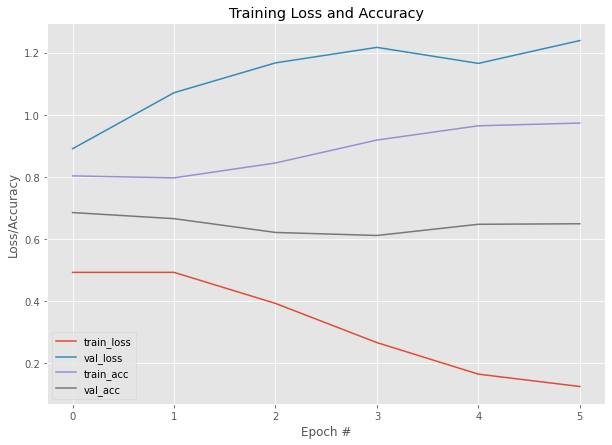

In [ ]:
plot_training(H, 6, os.path.join(base_dir, f'graph/{MODEL_NAME}.png'))

# Saving Fine-Tuned Model

In [ ]:
model.save_weights(os.path.join(base_dir, f'model/{MODEL_NAME}.h5'))

# Load best model

In [ ]:
%%time
EPOCHS          = EPOCHS
total_steps     = len(y_train) * BATCH_SIZE
train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / BATCH_SIZE) + 1
num_train_steps = steps_per_epoch * EPOCHS
# warmup_steps    = int(num_train_steps * 0.1)
warmup_steps    = 0

# Create the learning rate scheduler.
decay_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=2e-5,
      decay_steps=num_train_steps,
      end_learning_rate=0)

warmup_schedule = nlp.optimization.WarmUp(
        initial_learning_rate=2e-5,
        decay_schedule_fn=decay_schedule,
        warmup_steps=warmup_steps)

optimizer       = nlp.optimization.AdamWeightDecay(
        learning_rate=warmup_schedule,
        epsilon=1e-8,
        exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])

with strategy.scope():
    transformer = TFAutoModel.from_pretrained(MODEL)
    model2      = create_model(transformer, max_len=MAX_LENGTH)
    model2.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics='accuracy')
    
model2.summary()

- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 105)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 105)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   ((None, 105, 768), ( 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 768)]        0           tf_bert_model_1[0][0] 

In [ ]:
model2.load_weights(os.path.join(base_dir, f'checkpoint/{MODEL_NAME}/cp-01.h5'))
model2.evaluate(valid_dataset)

1/5 [=====>........................] - ETA: 28s - loss: 1.0203 - accuracy: 0.5938WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0037s vs `on_test_batch_end` time: 0.0446s). Check your callbacks.


5/5 [==============================] - 13s 3s/step - loss: 0.8905 - accuracy: 0.6852


[0.8905009031295776, 0.685245931148529]

# Evaluation

In [ ]:
val_pred = model2.predict(valid_dataset, verbose=1)
val_true = np.argmax(y_val, axis=1)
val_pred = np.argmax(val_pred, axis=1)
val_true.shape, val_pred.shape

2/5 [===========>..................] - ETA: 10sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0034s vs `on_predict_batch_end` time: 0.0387s). Check your callbacks.


5/5 [==============================] - 13s 3s/step


((610,), (610,))

In [ ]:
np.bincount(val_true)

array([116,  72, 422])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


              precision    recall  f1-score   support

           0       0.40      0.76      0.53       116
           1       0.47      0.19      0.27        72
           2       0.87      0.75      0.81       422

    accuracy                           0.69       610
   macro avg       0.58      0.57      0.54       610
weighted avg       0.74      0.69      0.69       610



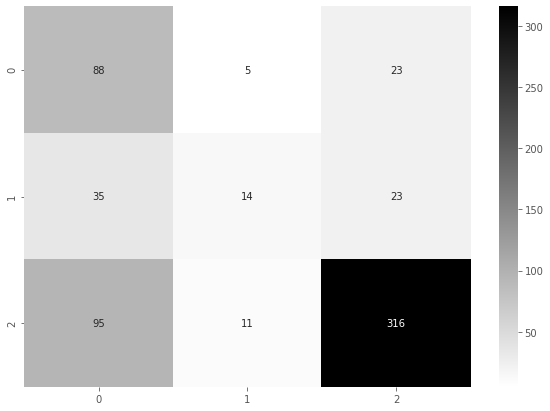

In [ ]:
import seaborn as sns

df_cm = pd.DataFrame(confusion_matrix(val_true, val_pred),
                     columns=np.arange(N_LABELS),
                     index=np.arange(N_LABELS))

plt.figure(figsize=(10,7))
ax = sns.heatmap(df_cm, cmap='binary', annot=True, fmt='d')
plt.savefig(os.path.join(base_dir, f'confusion_matrix/{MODEL_NAME}.png'))

print(classification_report(val_true, val_pred))

In [ ]:
accuracy_score(val_true, val_pred)

0.6852459016393443

In [ ]:
def multiclass_roc_auc_score(y_true, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_true = lb.transform(y_true)
    y_pred = lb.transform(y_pred)

    return roc_auc_score(y_true, y_pred, average=average)

In [ ]:
multiclass_roc_auc_score(val_true, val_pred)

0.6940502962040082

# Save prediction result for train/valid data

In [ ]:
val_pred = model2.predict(valid_dataset, verbose=1)
val_true = np.argmax(y_val, axis=1)

1/5 [=====>........................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0041s vs `on_predict_batch_end` time: 0.0369s). Check your callbacks.


5/5 [==============================] - 0s 43ms/step


In [ ]:
X_train          = {
    "input_ids": id_train,
    "attention_mask": mask_train
}

train_dataset    = (
    tf.data.Dataset
    .from_tensor_slices(X_train)
    .batch(BATCH_SIZE)
)

train_pred = model2.predict(train_dataset, verbose=1)
train_true = np.argmax(y_train, axis=1)

 2/43 [>.............................] - ETA: 2:21WARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0053s vs `on_predict_batch_end` time: 0.0376s). Check your callbacks.


43/43 [==============================] - 14s 330ms/step


In [ ]:
df_val_pred = pd.DataFrame(val_pred, columns=np.arange(N_LABELS))
df_val_pred.loc[:, 'label'] = val_true
print(df_val_pred.shape)
display(df_val_pred.head())

(610, 4)


0         1         2  label
0  0.074648  0.070190  0.855162      2
1  0.791145  0.121891  0.086964      1
2  0.123721  0.279253  0.597026      1
3  0.067629  0.098533  0.833838      0
4  0.103252  0.080557  0.816191      2

In [ ]:
df_true_pred = pd.DataFrame(train_pred, columns=np.arange(N_LABELS))
df_true_pred.loc[:, 'label'] = train_true
print(df_true_pred.shape)
display(df_true_pred.head())

(5479, 4)


0         1         2  label
0  0.720217  0.179686  0.100097      0
1  0.198642  0.075384  0.725974      2
2  0.025167  0.006613  0.968220      2
3  0.003988  0.007600  0.988412      2
4  0.026230  0.077119  0.896652      2

In [ ]:
df_val_pred.to_csv(os.path.join(base_dir, f'prediction/{MODEL_NAME}_val.csv'), index=False)

In [ ]:
df_true_pred.to_csv(os.path.join(base_dir, f'prediction/{MODEL_NAME}_train.csv'), index=False)